# Using Random Forest Classifiers to detect anomalies from FinBIF specimen data

Random Forest is recommended method by many scientific papers. It only evaluates a random subset of predictors to identify the best predictors instead of searching over all predictors. 

Down-sampling (‘balanced RF') is used in this method to reduce the bias of overlapping / imbalanced classes. See https://nsojournals.onlinelibrary.wiley.com/doi/full/10.1111/ecog.05615

Use the model by selecting the taxon_id variable and run the model.


## 1. Environment Setup and Configuration

In [1]:
from load_data import get_occurrence_data
from dotenv import load_dotenv
import os
import geopandas as gpd
import helpers
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import warnings
import numpy as np

warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

In [2]:

# Load environment variables
load_dotenv()
virva_access_token = os.getenv('VIRVA_ACCESS_TOKEN')
open_access_token = os.getenv('ACCESS_TOKEN')
access_email = os.getenv('ACCESS_EMAIL')

# API and data file configuration
time = '2020-01-01'
country_id = "ML.206"
selected = 'unit.unitId,unit.taxonVerbatim,unit.linkings.taxon.scientificName,unit.linkings.taxon.nameEnglish,unit.linkings.taxon.id,gathering.conversions.dayOfYearBegin'
taxon_id = 'MX.38950' # komealupiini # Change here the taxon ID you want to use. IDs can be found from api.laji.fi taxon endpoint
coordinateAccuracyMax='100'
base_url = 'https://api.laji.fi/v0/warehouse/private-query/unit/list?'
pages = 'all'

# File paths
presence_points_path = f'data_obs/{taxon_id}_presence_RF.gpkg'
background_samples_path = f'data_obs/{taxon_id}_absent_RF.gpkg'
output_path = f'data_results/{taxon_id}_predicted_RF.gpkg'
sample_points_area = 'data_env/SuomenValtakunta_2024_100k.shp'
corine_path = 'data_env/corine_classified.tif'
raster_paths = ['data_env/dem.tif', 'data_env/nvdi.tif', 'data_env/rain.tif', 'data_env/temp.tif']
raster_paths_for_buffer = ['data_env/tree_vol.tif']

# Parameters for data processing
grid_size_for_duplicates = 1000
corine_buffer_size = 100
checkerboard_split_grid_size = 10000

# Define feature columns for the model
feature_columns = ['x', 'y', 'Urban', 'Park', 'Rural', 'Forest', 'Open forest', 'Fjell', 'Open area', 'Wetland', 'Open bog', 'Freshwater', 'Marine', 'dem', 'nvdi', 'rain', 'temp', 'tree_vol', 'gathering.conversions.dayOfYearBegin']



# 2. Download or Load Presence Data

In [3]:

# Load or download presence data
if os.path.exists(presence_points_path): 
    print(f"Using present data from the memory...")
    presence_points = gpd.read_file(presence_points_path)
else:
    print("Downloading present data from the API...")
    data_url = f'{base_url}selected={selected}&page=1&pageSize=10000&taxonId={taxon_id}&countryId={country_id}&coordinateAccuracyMax={coordinateAccuracyMax}&time={time}/&geoJSON=true&featureType=CENTER_POINT&access_token={virva_access_token}&personEmail={access_email}' 
    presence_points = get_occurrence_data(data_url, pages=pages).to_crs(3067)
    presence_points[presence_points['unit.linkings.taxon.id'] == f'http://tun.fi/{taxon_id}'] # Select only the specific taxon if the api returned many
    presence_points.to_file(presence_points_path, driver='GPKG')

# Remove duplicates using grid size
presence_points = helpers.remove_duplicates(presence_points, grid_size_for_duplicates)
print(f"Present data processed. Number of observations: {len(presence_points)}")


Using present data from the memory...
grid created
In total 7366 duplicates were removed with a grid size 1000
Present data processed. Number of observations: 4860


# 3. Generate Background Sample Data and Combine

Background sample data turned out to be a better and more robust solutions than using data from similar species. Real absence data would be good too, but it is not common enough. Read more: https://www.sciencedirect.com/science/article/pii/S0304380023003344

In [4]:
# Generate background data by sampling points from the study area
background_samples = helpers.sample_polygon(sample_points_area, count=len(presence_points))

# Add needed columns to background samples so that they are not removed
background_samples['unit.unitId'] = "sample_id"
background_samples['unit.linkings.taxon.scientificName'] = "sample_scientificname"

# Randomly assign 'dayOfYearBegin' to background samples based on the distribution in presence data
presence_days = presence_points['gathering.conversions.dayOfYearBegin'].dropna()  # Drop NaN values if any
background_samples['gathering.conversions.dayOfYearBegin'] = np.random.choice(
    presence_days, 
    size=len(background_samples), 
    replace=True
)

# Combine presence and absence data into a single GeoDataFrame
merged = helpers.stack_geodataframes(presence_points, background_samples, add_class_label=True)

Generating sample background points from the file data_env/SuomenValtakunta_2024_100k.shp...
In total 4860 background sample points were genearated


# 4. Visualize Presence and Background Samples

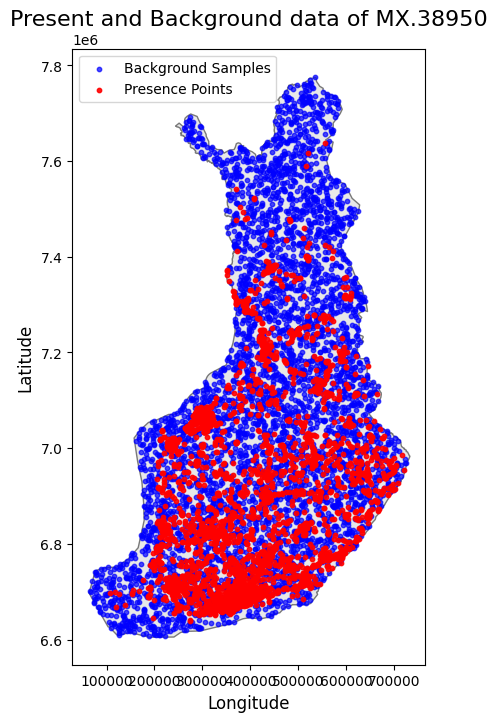

In [5]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the background polygons
borders = gpd.read_file(sample_points_area)
borders.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5, label='Background Polygons')

# Plot the background samples
background_samples.plot(
    ax=ax,
    color='blue',  # Use a distinct color
    markersize=10,
    alpha=0.7,
    label='Background Samples'
)

# Plot the presence points
presence_points.plot(
    ax=ax,
    color='red',  # Use a distinct color
    markersize=10,
    alpha=0.9,
    label='Presence Points'
)

# Add a legend
plt.legend()

# Add labels and a title for better clarity
ax.set_title(f'Present and Background data of {taxon_id}', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Show the plot
plt.show()


# 5. Enrich Data with Environmental Features

In [6]:
# Add land cover proportions and raster values
merged = helpers.calculate_land_cover_proportions(merged, corine_path, corine_buffer_size)
merged = helpers.extract_raster_values_with_buffer(merged, raster_paths_for_buffer)
merged = helpers.extract_raster_values(merged, raster_paths).dropna()

# Extract x and y coordinates for machine learning features
merged['x'] = merged.geometry.x
merged['y'] = merged.geometry.y

print(f"\nAfter enrichment and dropping points outside of the raster extents, the dataset has {len(merged)} samples.")

print(merged.describe())

Calculating corine land cover proportions...
Processing raster: data_env/tree_vol.tif with buffer of 100 meters
Processing raster: data_env/dem.tif
Processing raster: data_env/nvdi.tif
Processing raster: data_env/rain.tif
Processing raster: data_env/temp.tif

After enrichment and dropping points outside of the raster extents, the dataset has 9550 samples.
       gathering.conversions.dayOfYearBegin        class        Urban  \
count                           9550.000000  9550.000000  9550.000000   
mean                             184.102618     0.507644     0.197070   
std                               47.073837     0.499968     0.274786   
min                                1.000000     0.000000     0.000000   
25%                              158.000000     0.000000     0.000000   
50%                              178.000000     1.000000     0.000000   
75%                              204.000000     1.000000     0.328947   
max                              363.000000     1.000000  

# 6. Split Data into Training and Testing Sets

In [12]:
# Split back to the train and tast datasets using checkerboard split to reduce spatial autocorrelation
train_points, test_points = helpers.checkerboard_split(merged, 100000) # Note: this may not be the best way to divide data into training and testing sets but difficult to find better options

# Assign spatial weights to account for over-represented areas sampling bias
train_points['sample_weights'] = helpers.distance_weights(train_points)
test_points['sample_weights'] = helpers.distance_weights(test_points)

# Normalize feature columns
train_points = helpers.normalise_columns(train_points) # Normalise present data
test_points = helpers.normalise_columns(test_points) # Normalise absent data

# Prepare feature matrices and target variables
X_train = train_points[feature_columns]
y_train = train_points['class']
sample_weights_train = train_points['sample_weights']

X_test = test_points[feature_columns]
y_test = test_points['class']
sample_weights_test = test_points['sample_weights']


<Axes: >

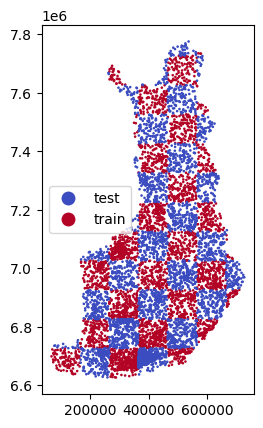

In [13]:
# we'll re-merge them for plotting purposes
train_points['split'] = 'train'
test_points['split'] = 'test'
checker = helpers.stack_geodataframes(train_points, test_points)
checker.plot(column='split', markersize=0.75, legend=True, cmap='coolwarm')

# 7. Train Random Forest Model

In [8]:
# Train a balanced Random Forest model
rf = RandomForestClassifier(class_weight="balanced_subsample")
rf.fit(X_train, y_train, sample_weights_train)

# Evaluate the model
rf_predictions = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:, 1]

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))
print(f"Accuracy: {accuracy_score(y_test, rf_predictions):.2f}")
print(f"ROC AUC: {roc_auc_score(y_test, rf_probs):.2f}\n") # ROC AUC = Receiver Operating Characteristic Area Under the Curve. AUC is a well-known metric in SDM. It measures discrimination – i.e. the ability of the model to discriminate presences from absences

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.92      2393
         1.0       0.92      0.91      0.92      2485

    accuracy                           0.92      4878
   macro avg       0.92      0.92      0.92      4878
weighted avg       0.92      0.92      0.92      4878

Accuracy: 0.92
ROC AUC: 0.96



# 8. Visualize Prediction Probabilities

In [9]:
# Extract real presence points
real_presence_points = test_points[(test_points['class'] == 1) & (test_points['unit.unitId'] != 'sample_id')]

# Add predictions and probabilities to real presence points
real_presence_points['rf_prediction'] = rf_predictions[test_points['class'] == 1]
real_presence_points['rf_probability'] = rf_probs[test_points['class'] == 1]

# Normalize probabilities for visualization
real_presence_points['rf_probability_normalized'] = helpers.normalise_columns(real_presence_points[['rf_probability']])

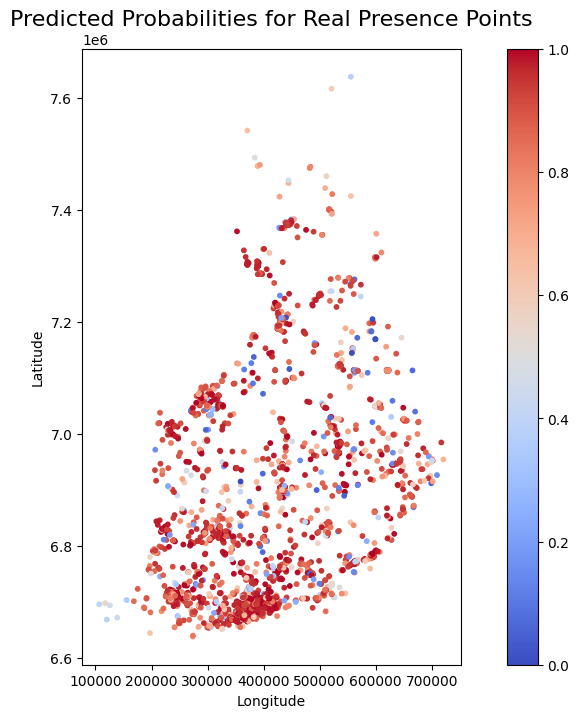

In [10]:
# Create a map visualization
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot real presence points with probabilities
real_presence_points.plot(
    column='rf_probability_normalized',
    cmap='coolwarm',
    legend=True,
    markersize=10,  # Adjust size as needed
    ax=ax
)

# Add titles and labels
ax.set_title('Predicted Probabilities for Real Presence Points', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


In [11]:
# Export to GPKG
real_presence_points.to_file(output_path, driver='GPKG')